# 1.7 signac-flow minimal example (with HOOMD-blue)

## About

<div class="alert alert-warning">

Note: This example is in the process of being updated for the latest versions of signac and signac-flow.
    
    
</div>

This notebook contains a minimal example for running a *signac-flow* project from scratch.
The example demonstrates how to compare an ideal gas with a Lennard-Jones (LJ) fluid by calculating a p-V phase diagram.

This examples uses the general-purpose simulation toolkit [HOOMD-blue](http://glotzerlab.engin.umich.edu/hoomd-blue/) for the execution of the molecular-dynamics (MD) simulations.

## Author

Carl Simon Adorf

## Before you start

This example requires signac, signac-flow, HOOMD-blue and numpy.
You can install these package for example via conda:
```
conda install -c conda-forge hoomd numpy signac signac-flow
```

In [1]:
import flow
import hoomd
import numpy as np
import signac

# Initialize the HOOMD-blue execution context
hoomd.context.initialize("")

project_root = "projects/tutorial-signac-flow-hoomd-blue"
project = signac.init_project("FlowTutorialHOOMD-BlueProject", project_root)

HOOMD-blue 2.9.3 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 01/11/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU


We want to generate a pressure-volume phase diagram for a Lennard-Jones fluid with molecular dynamics (MD) using the general-purpose simulation toolkit HOOMD-blue (http://glotzerlab.engin.umich.edu/hoomd-blue/).

We start by defining two functions, one for the initialization of our simulation and one for the actual execution.

In [2]:
from math import ceil


def init(N):
    with hoomd.context.SimulationContext():
        n = ceil(pow(N, 1 / 3))
        assert n ** 3 == N
        hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.0), n=n)
        hoomd.dump.gsd("init.gsd", period=None, group=hoomd.group.all())


def sample_lj(N, sigma, seed, kT, tau, p, tauP, steps, r_cut):
    from hoomd import md

    hoomd.init.read_gsd("init.gsd", restart="restart.gsd")
    group = hoomd.group.all()
    hoomd.dump.gsd("restart.gsd", truncate=True, period=100, phase=0, group=group)
    lj = md.pair.lj(r_cut=r_cut, nlist=md.nlist.cell())
    lj.pair_coeff.set("A", "A", epsilon=1.0, sigma=sigma)
    md.integrate.mode_standard(dt=0.005)
    md.integrate.npt(group=group, kT=kT, tau=tau, P=p, tauP=tauP)
    hoomd.analyze.log("dump.log", ["volume"], 100, phase=0)
    hoomd.run_upto(steps)

We want to use **signac** to manage our simulation data and bundle all operations modifying our data space in a `Operations` class. This will make it easier later to execute these operations *by name*.

The `estimate` operation stores an ideal gas estimation of the volume for the given system.
The `sample` operation actually executes the MD simulation as defined in the previous cell.
We define all operations as static methods of an `Operations` class in order to keep them in a separate namespace.

In [3]:
def estimate(job):
    sp = job.statepoint()
    job.document["V"] = sp["N"] * sp["kT"] / sp["p"]


def sample(job):
    import hoomd

    with job:
        with hoomd.context.SimulationContext():
            try:
                sample_lj(steps=5000, **job.statepoint())
            finally:
                job.document["sample_step"] = hoomd.get_step()

In [4]:
for job in project:
    print(job.document)

{'V': 102.4, 'sample_step': 5000}
{'V': 341.3333333333333, 'sample_step': 5000}
{'V': 512.0, 'sample_step': 5000}
{'V': 113.77777777777777, 'sample_step': 5000}
{'V': 256.0, 'sample_step': 5000}
{'V': 146.28571428571428, 'sample_step': 5000}
{'V': 128.0, 'sample_step': 5000}
{'V': 204.8, 'sample_step': 5000}
{'V': 1024.0, 'sample_step': 5000}
{'V': 170.66666666666666, 'sample_step': 5000}


Now that we have defined all *operations* it's time to embed them into a general *workflow*.
For this purpose we specialize a `flow.FlowProject`.

The workflow is controlled by two core functions: `classify()` and `next_operation()`:
 - The `classify()` function allows us to *label* our jobs and get a good overview of the project *status*. This is especially important once the data space becomes larger and more complex and operations more expensive.
 - The `next_operation()` functions helps to automate the workflow by identifying the next required operation for each job.

In [5]:
class MyProject(flow.FlowProject):
    def classify(self, job):
        yield "init"
        if "V" in job.document:
            yield "estimated"
        if job.document.get("sample_step", 0) >= 5000:
            yield "sampled"

    def next_operation(self, job):
        labels = set(self.classify(job))
        if "V" not in job.document:
            return "estimate"
        if "sampled" not in labels:
            return "sample"

We need to use the `get_project()` *class method* to get a project handle for this special project class.

In [6]:
project = MyProject.get_project(root=project_root)

Now it's time to actually generate some data! Let's initialize the data space!


In [7]:
# Uncomment the following two lines if you want to start over!
# for job in project:
#     job.remove()

for p in np.linspace(0.5, 5.0, 10):
    sp = dict(N=512, sigma=1.0, seed=42, kT=1.0, p=p, tau=1.0, tauP=1.0, r_cut=2.5)
    with project.open_job(sp):
        init(N=sp["N"])

notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles


The `print_status()` function allows to get a quick overview of our project's *status*:

In [8]:
project.print_status(detailed=True, parameters=["p"]);

Fetching status: 0it [00:00, ?it/s]

Fetching labels: 0it [00:00, ?it/s]


Overview:

Total # of jobs: 0

label
-------


operation
-----------


Detailed View:

job id
--------


[U]:unknown [R]:registered [I]:inactive [S]:submitted [H]:held [Q]:queued [A]:active [E]:error




The next cell will attempt to execute all operations by cycling through jobs and operations until no *next operations* are defined anymore.

We limit the max. number of cycles to prevent accidental infinite loops, the number of cycles is arbitrary.

In [9]:
for i in range(3):
    for job in project:
        for j in range(5):
            next_op = project.next_operation(job)
            if next_op is None:
                break
            print("execute", job, next_op)
            globals()[next_op](job)
            assert next_op != project.next_operation(job)
        else:
            raise RuntimeError("Reached max. # cycle limit!")

Let's double check the project status.

In [10]:
project.print_status();

Fetching status: 0it [00:00, ?it/s]

Fetching labels: 0it [00:00, ?it/s]


Overview:

Total # of jobs: 0

label
-------


operation
-----------





After running all operations we can make a brief examination of the collected data.

In [11]:
def get_volume(job):
    log = np.genfromtxt(job.fn("dump.log"), names=True)
    N = len(log)
    return log[int(0.5 * N) :]["volume"].mean(axis=0)


for job in project:
    print(job.statepoint()["p"], get_volume(job), job.document.get("V"))

5.0 593.777573608 102.4
1.5 791.728728196 341.3333333333333
1.0 903.9505265920001 512.0
4.5 600.001185592 113.77777777777777
2.0 741.011125508 256.0
3.5 634.2033970919999 146.28571428571428
4.0 614.750191224 128.0
2.5 686.3928969000001 204.8
0.5 1139.3264905719998 1024.0
3.0 662.2078703 170.66666666666666


For a better presentation of the results we need to aggregate all results and sort them by pressure.

*The following code requires matplotlib.*

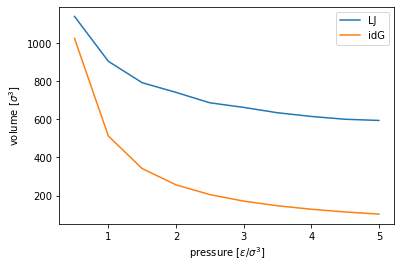

In [12]:
%matplotlib inline
# Display plots within the notebook

from matplotlib import pyplot as plt

V = dict()
V_idg = dict()

for job in project:
    V[job.statepoint()["p"]] = get_volume(job)
    V_idg[job.statepoint()["p"]] = job.document["V"]

p = sorted(V.keys())
V = [V[p_] for p_ in p]
V_idg = [V_idg[p_] for p_ in p]

plt.plot(p, V, label="LJ")
plt.plot(p, V_idg, label="idG")
plt.xlabel(r"pressure [$\epsilon / \sigma^3$]")
plt.ylabel(r"volume [$\sigma^3$]")
plt.legend()
plt.show()

Uncomment and execute the following line to remove all data and start over.

In [13]:
# %rm -r projects/tutorial-signac-flow-hoomd-blue/workspace